## Load necessary python libraries

In [1]:
import os
import tifffile
import numpy as np
import matplotlib.pyplot as plt

import bigfish
import bigfish.stack as stack
import bigfish.detection as detection
import bigfish.multistack as multistack
import bigfish.plot as plot

from runBigfishDetection import saveSpotsNPZ
from bigfish.detection.utils import get_object_radius_pixel
from dask.array.image import imread as imr
from imaris_ims_file_reader.ims import ims
from kneed import KneeLocator

print("Big-FISH version: {0}".format(bigfish.__version__))
print("numpy version: {0}".format(np.__version__))

Big-FISH version: 0.6.2
numpy version: 1.23.0


In [2]:
from order_spot import * 

import sys 

sys.path.append('/media/raphael/data/works/notebooks/notebook_scripts_perso/full_pipeline_perso/')
from follow_cells import *

## Specify voxel and object size

In [4]:
voxelRadius = (700, 110, 110)
objectRadius = (700, 105, 105)

## Give Input path and load data

In [11]:
homeFolder = '/media/raphael/Genia_ordi/20240612_c3.45_ON_01_w1SPI-488/S2/'
nameKey = 'c3.45_ON_01_w1SPI-488_s'

imsQ = '2'
cellNumber = '15'

pathToTimeFrames = homeFolder+nameKey+imsQ+'/*.tif'
path_input = homeFolder+nameKey+imsQ+'/cell_'+str(cellNumber)+'/'
nucleiStackForm = nameKey+imsQ+"_cell_"
pathToTimeFramesCell = homeFolder+nameKey+imsQ+'/cell_'+str(cellNumber)+'/*.tif'
stackCell = imr(pathToTimeFramesCell)
MaxTimePoint = stackCell.shape[0]

In [12]:
pathToTimeSequenceMask = homeFolder+nameKey+imsQ+'/mask_'+str(cellNumber)+'/*.tif'
maskcell = imr(pathToTimeSequenceMask)

mipSequenceMask= np.max(maskcell, axis=1)
maskcell.shape

(721, 31, 126, 125)

## Read a list of images and use it to find detection threshold  (bigfish default)

Total number of images : 720
Detected threshold:16.0


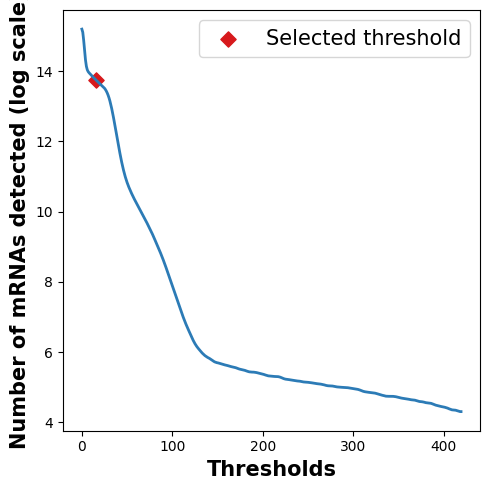

In [7]:
images = []
spots_list=[]
MaxTimePoint = 721
for t in range(1,MaxTimePoint,1):

    path = os.path.join(path_input, nucleiStackForm+str(cellNumber)+'_t'+str(f"{t:03}")+".tif")
    rna = stack.read_image(path)
    
    rna = get_cells(rna,maskcell[t-1],int(cellNumber))
    
    images.append(rna)

n=len(images)
print("Total number of images : "+str(n))

spots_image_list, threshold_image_list = detection.detect_spots(
    images=images, 
    return_threshold=True, 
    voxel_size=voxelRadius,  # in nanometer (one value per dimension zyx)
    spot_radius=objectRadius)  # in nanometer (one value per dimension zyx)

print('Detected threshold:'+str(threshold_image_list))
plot.plot_elbow(
    images=images, 
    voxel_size=voxelRadius, 
    spot_radius=objectRadius)


## Find detection threshold (using difference curve approach)

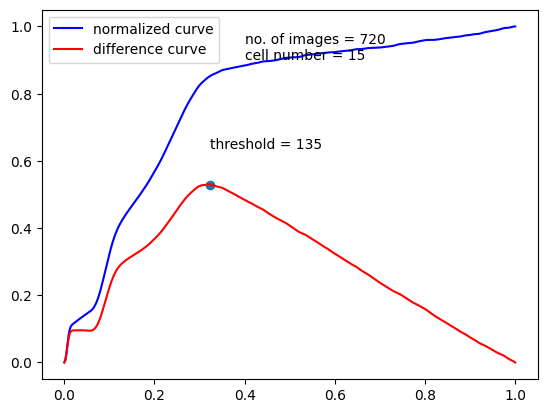

In [13]:
thresholds, count_spots, threshold = detection.get_elbow_values(
        images,
        voxel_size=voxelRadius,
        spot_radius=objectRadius
)

knees = []
norm_knees = []

kneedle = KneeLocator(
    thresholds, count_spots, S=1, curve="convex", direction="decreasing", online=False)

xx = np.argmax(kneedle.y_difference)
plt.plot(kneedle.x_normalized, kneedle.y_normalized, label = 'normalized curve', color='blue')
plt.plot(kneedle.x_difference, kneedle.y_difference, label = 'difference curve', color='red')
plt.scatter(kneedle.x_difference[xx], kneedle.y_difference[xx])
plt.text(kneedle.x_difference[xx], kneedle.y_difference[xx]*1.2, 'threshold = '+str(kneedle.x[xx]))
plt.text(np.max(kneedle.x_difference)*0.8/2, 0.95, 'no. of images = '+str(len(images)))
plt.text(np.max(kneedle.x_difference)*0.8/2, 0.90, 'cell number = '+str(cellNumber))
plt.legend()

## Check performance of different thresholds

Automatic Threshold (gradient) = 16.0
Automatic Threshold (difference) = 135


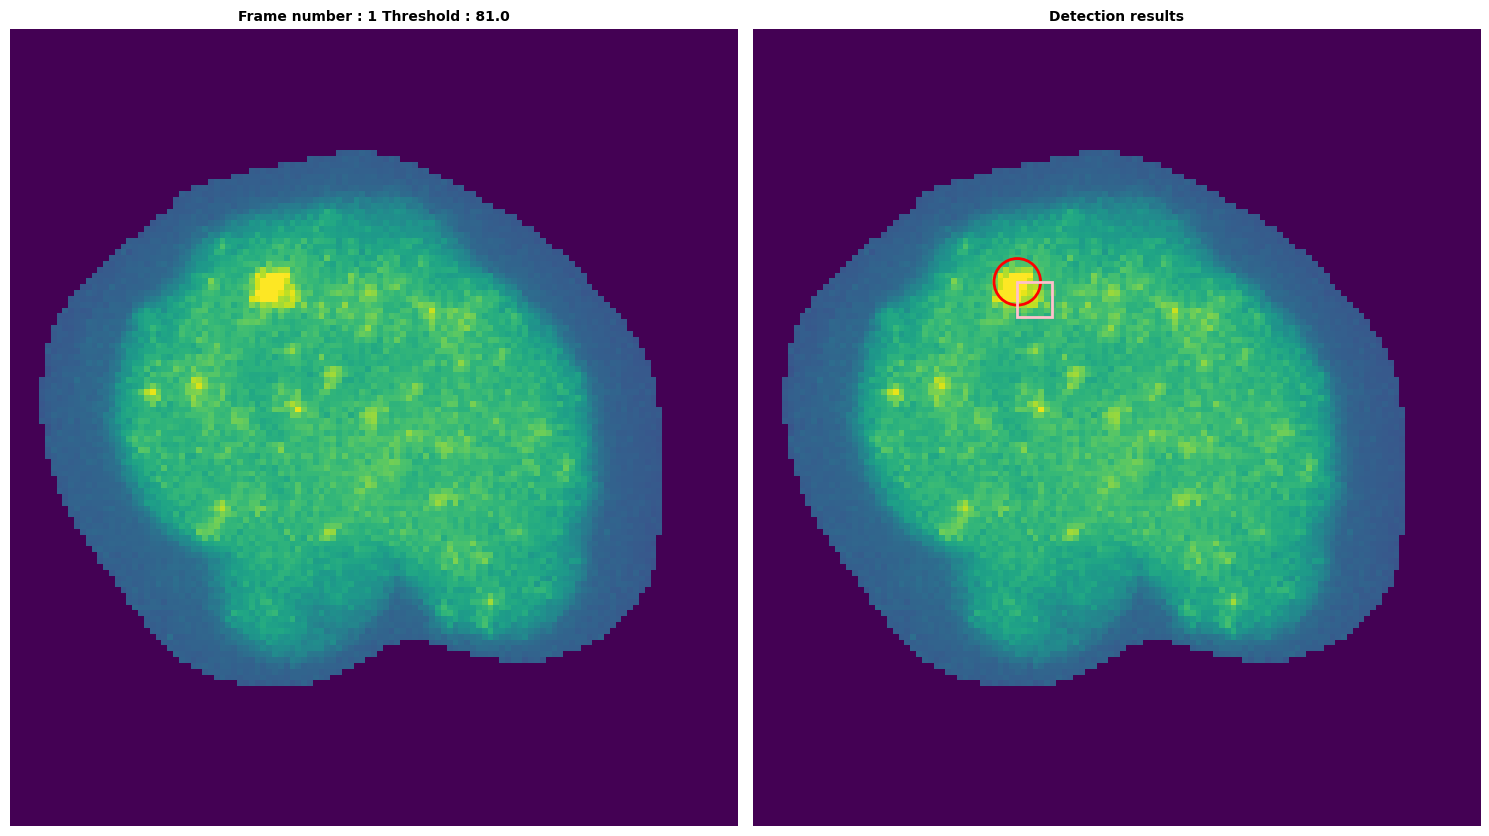

Automatic Threshold (gradient) = 16.0
Automatic Threshold (difference) = 135


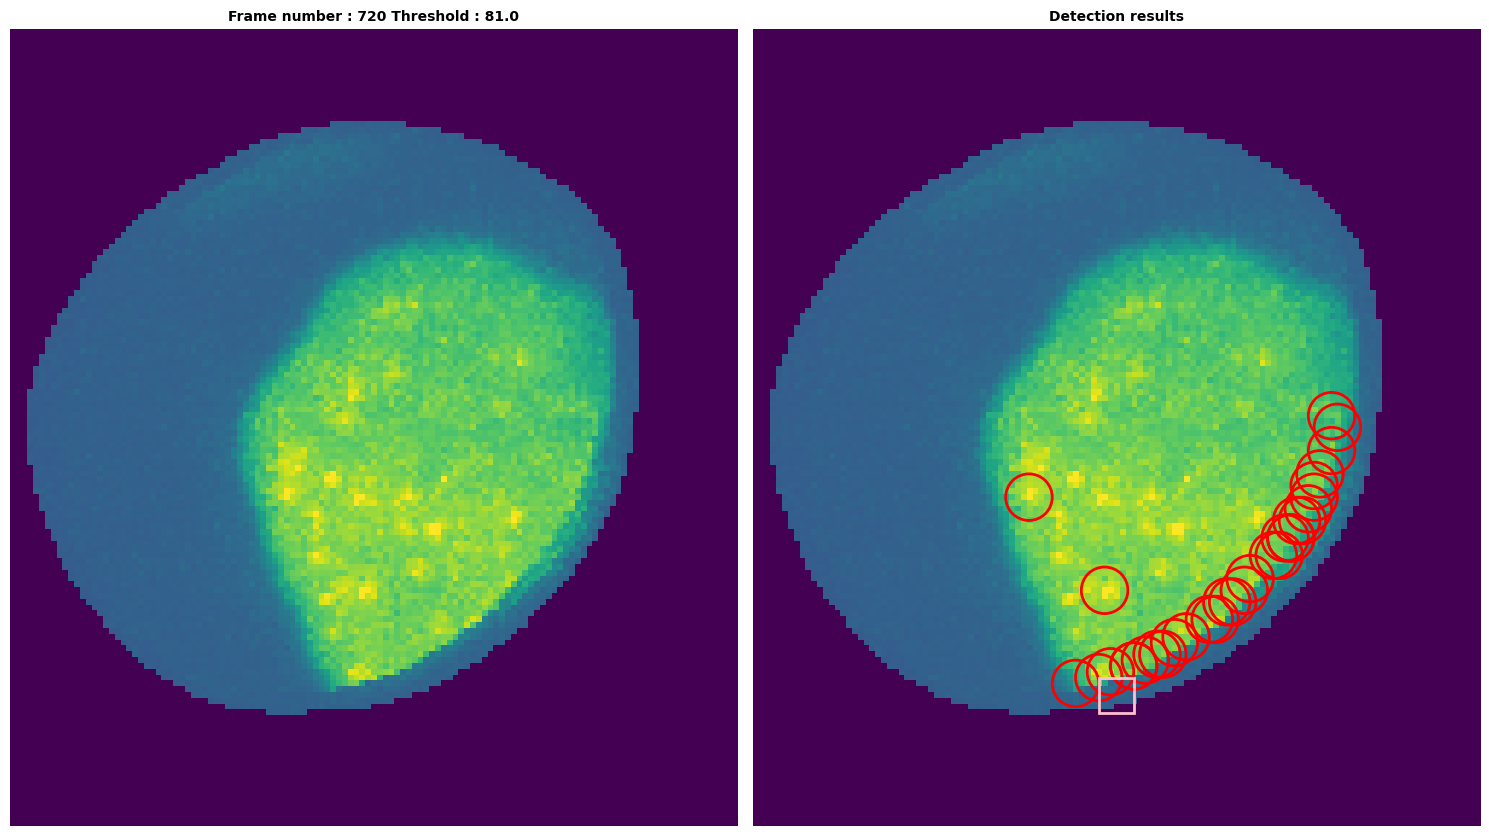

In [10]:

for t in [1,720]:
    path = os.path.join(path_input, nucleiStackForm+str(cellNumber)+'_t'+str(f"{t:03}")+".tif")
    rna = stack.read_image(path)
    
    rna = get_cells(rna,maskcell[t-1],int(cellNumber))
    
    
    rna_mip = stack.maximum_projection(rna)
    thrs = 135*0.6

    # spot radius
    spot_radius_px = detection.get_object_radius_pixel(
        voxel_size_nm=voxelRadius,
        object_radius_nm=objectRadius, 
        ndim=3)

    # LoG filter
    rna_log = stack.log_filter(rna, sigma=spot_radius_px)

    # local maximum detection
    mask = detection.local_maximum_detection(rna_log, min_distance=spot_radius_px)

    # thresholding
    threshold = detection.automated_threshold_setting(rna_log, mask)
    print('Automatic Threshold (gradient) = '+str(threshold_image_list))
    spots_current, _ = detection.spots_thresholding(rna_log, mask, thrs)
    print('Automatic Threshold (difference) = '+str((kneedle.x[xx])))
    
    spots_currentGrd, _ = detection.spots_thresholding(rna_log, mask, threshold_image_list)
    spots_currentKneedl, _ = detection.spots_thresholding(rna_log, mask, np.float64(kneedle.x[xx]))

    plot.plot_detection(rna_mip, 
                            spots=[spots_current, spots_currentKneedl], 
                            shape=["circle", 'square'], 
                            radius=[4,6], 
                            color=["red",'pink'],
                            linewidth=[2,2], 
                            fill=[False,False],
                            title='Frame number : '+ str(t)+ ' Threshold : '+str(thrs),
                            contrast=True)